--- 
# Sandbox (Faune)
Tests for each part of this project

---

### TODOs and notes 

- Either fit a logistic regression or leave the results as is 
- Look at the correlation between the results and the errors in the API 
- Try to reproduce the EAR from the paper ?
- Write the report
- Write background -> what are LLMs, why should we use them for sentiment analysis, why is sentiment analysis important in crypto, what is a prompt and how to construct it, etc.
- Add trading on sentiment part 
- show the bitcoin returns graph, heatmap of logistic regression, predicted direction vs direction with datetime index

### Imports

In [1]:
#external libraries
import polars as pl
from datetime import date
import nest_asyncio
import os

#internal libraries
from prompts import process_in_batches, import_data, preprocess_responses
from utils import compute_sentiment_ear, local_projection_irf_polars, get_logistic_regression, get_btc_returns
import matplotlib.pyplot as plt

## Tests for EAR and IRF with scores

In [2]:
scores = pl.read_csv('scores.csv')

In [3]:
scores.head()

date,increase,decrease,diff,score
str,i64,i64,i64,f64
"""2017-09-29""",0,1,-1,-1.0
"""2017-10-31""",2,0,2,1.0
"""2017-11-12""",1,0,1,1.0
"""2017-11-13""",0,0,0,NaN
"""2017-11-14""",0,1,-1,-1.0


In [4]:
sentiment = scores.select('score').to_series().fill_nan(None).fill_null(strategy='mean') #change later ?

In [5]:
ear = compute_sentiment_ear(sentiment=sentiment)

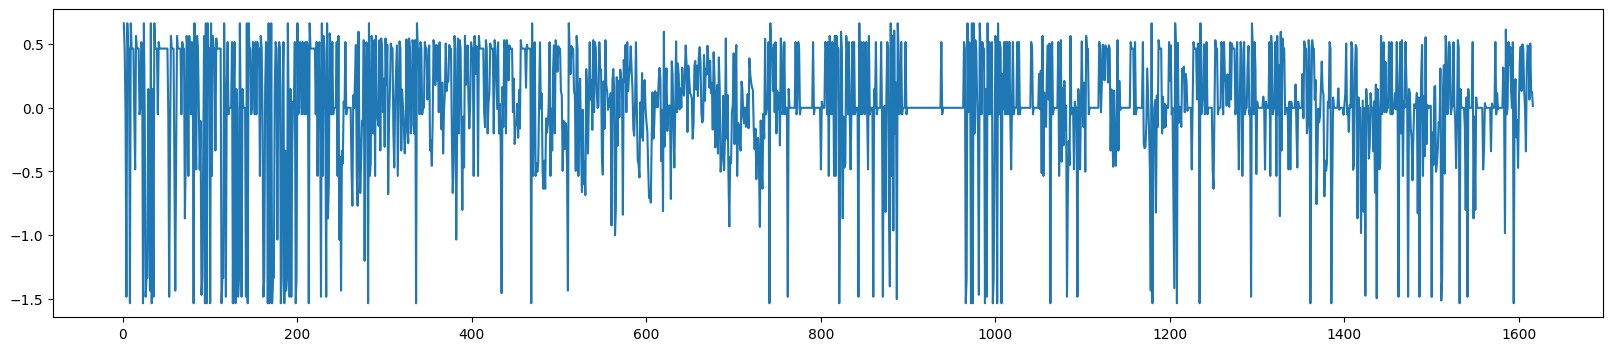

In [6]:
plt.figure(figsize=(20,4)) #redo with good results 
plt.plot(ear)

In [10]:
scores= scores.with_columns(pl.col('date').str.to_date())

In [11]:
returns = get_btc_returns(scores=scores)

YF.download() has changed argument auto_adjust default to True


In [ ]:
local_projection_irf_polars(y=returns.select('returns'), x=sentiment, control=sentiment) #fix when we have correct scores

ShapeError: could not create a new DataFrame: height of column 'x' (1617) does not match height of column 'y' (2658)

## Importing data test

In [2]:
titles = import_data()

In [17]:
pl.config.Config.set_tbl_width_chars(-1)
titles.drop('prompts').head()

date,title
date,str
2017-09-29,"""Edward Snowden: Zcash Is 'Most Interesting Bitcoin Alternative'"""
2017-10-31,"""Bitcoin Cash: Hard Fork Planned for Better EDA on Nov 13"""
2017-10-31,"""Bitcoin Cash Developers Propose Date for November Hard Fork"""
2017-11-12,"""Confusion and Euphoria As Bitcoin Cash Tops $30 Billion"""
2017-11-13,"""Bitcoin Cash Hard Forks In Bid to Ease Mining Difficulties"""


## Prompting test

### Basic sentences
Adapted from the mistral website

In [3]:
responses = preprocess_responses()

In [5]:
responses.write_csv("scores.csv")

In [ ]:
# nest_asyncio.apply()
# prompts = titles.select('prompts').to_series().to_list()
# csv_path = "responses_2017_2024.csv"
# first_write = not os.path.exists(csv_path)

# async for batch in process_in_batches(prompts, batch_size=200, concurrency=10):
#     batch_df = pl.DataFrame({
#         "index": [r[0] for r in batch],
#         "prompt": [r[1] for r in batch],
#         "response": [r[2] for r in batch],
#     })

#     csv_string = batch_df.write_csv(separator=",", include_header=first_write)
#     with open(csv_path, "a", encoding="utf-8") as f:
#         f.write(csv_string)

#     first_write = False
#     print(f"Wrote {len(batch)} rows to {csv_path}")


Processing prompts 0 to 199...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 200 to 399...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 400 to 599...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 600 to 799...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 800 to 999...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 1000 to 1199...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 1200 to 1399...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 1400 to 1599...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 1600 to 1799...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 1800 to 1999...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 2000 to 2199...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 2200 to 2399...
Wrote 200 rows to responses_2017_2024.csv
Processing prompts 2400 to 2599...
Wrote 200 rows to responses_2017_2024.csv
Processing 